# Question 2: **Grouping Customers Together**

In [ ]:
import pandas as pd 
import numpy as np
import datetime as dt
from datetime import datetime
import numpy as np
from tqdm import tqdm
import re
from collections import Counter
import warnings

In [ ]:
warnings.filterwarnings(action='ignore')

## 2.1.- Getting your data + feature engineering

First we read the dataset from the `csv` file to start working with it.

In [2]:
data=pd.read_csv('bank_transactions.csv')

20 own features:

- Max of transaction 
- Min of transaction 
- Most frequent time of day 
- Age of Costumer from the transaction
- Day of the Week of most Trasactions
- Month of most Trasactions 
- Month when they had more money 
- Num of transactions per month 
- Location where more money is sent from
- Season of most transactions 
- Does the customer change its sex? (1-YES | 0-NO) 
- Period of the day when most transactions are done 
- Section of the population: {Students, Adults, Retired} when last transaction
- Rich or not overall
- If the person's balance is very volatile or not. (1-YES | 0-NO) 
- Log(Account Balance) on average || If Account==0 -> log()=-1
- Increment CustAccountBalance in the year  
- Total amount spent on transactions 
- How many cities have been visitied by that person 
- How many transactions are done at night.


In [ ]:
data.dropna(inplace=True)

In [ ]:
data.TransactionDate=pd.to_datetime(data.TransactionDate)

In [ ]:
data.CustomerDOB=pd.to_datetime(data.CustomerDOB)

In [ ]:
data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

<AxesSubplot:>

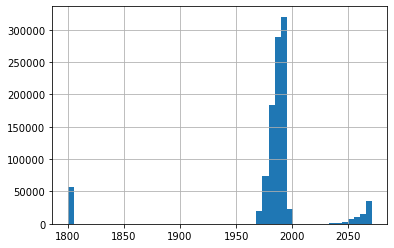

In [7]:
data.CustomerDOB.dt.year.hist(bins=50)

In [8]:
data.loc[data.CustomerDOB.dt.year>2000,'CustomerDOB']=data.loc[data.CustomerDOB.dt.year>2000,'CustomerDOB']-pd.DateOffset(years=100)

We can just drop the data from the people born in 1800s, or consider there is a mistake with the rounding and they are born in 2000, but considering that the dataset is from 2016, we don't think there were 50.000 16-y.o making bank transactions in 2016.

In [9]:
data.loc[data.CustomerDOB.dt.year==1800,'CustomerDOB']=data.loc[data.CustomerDOB.dt.year==1800,'CustomerDOB']+pd.DateOffset(years=200)

<AxesSubplot:>

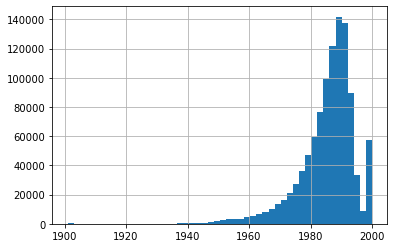

In [10]:
data.CustomerDOB.dt.year.hist(bins=50)

In [11]:
data.CustomerDOB[data.CustomerDOB.dt.year==2000].count()

56561

In [12]:
data['TransactionAmount (INR)'] = data['TransactionAmount (INR)'].astype(int)

Let's try to sort out the locations:

Make a list of the cities with length 1 and then, for the ones that have larger length, looks which one matches and then put it. If non matches, oh well :( . 

Here we create a list with all the locations formed of 1 word, which we are going to consider to be the actual citie names.

In [15]:
cities=[]

for i in data.CustLocation:
    if len(i.split())==1 and bool(re.match('[A-Z]',i)):
        cities.append(i)
cities=np.unique(cities)

Now, for all the `CustLocations` that have length greater than $1$, we will see which of the existing do they match and substitute it to be able to work with the data. If there is no match, we assign a `-`.

In [127]:
locations=[]
for i in tqdm(range(len(data))):
    if len((data.CustLocation.iloc[i]).split())>1:
        k,j=0,0
        while(k==0):
            if j==len(cities)-1:
                k=1
                locations.append('-')
                pass
            if cities[j] in data.CustLocation.iloc[i]:
                locations.append(cities[j])
                k+=1
            j+=1
    else:
        locations.append(data.CustLocation.iloc[i])

100%|████████████████████████████████| 1041614/1041614 [26:43<00:00, 649.75it/s]


In [151]:
locations=locations[0:len(locations)-2]

In [152]:
data['Location']=locations

In [153]:
data.Locations[data.Locations=='-'].count()

6036

## Let's make the new features for the DataSet

In [6]:
costumers=data['CustomerID']

In [7]:
costumers=np.unique(costumers)

Now that we have a string with all the costumers, we will search for all the extra features that we have decided to put into the dataset, we will build a new one with the previous and the new features where we also replace the old `CustLocation` by what we have previously named as `Location.` 

In [60]:
def get_features(id):
    
    features={}
    
    t=data[data['CustomerID']==id]
    
    features['CustomerID']=id
    
    #Number of Transactions
    features['N_Transactions']=len(t)
    
    #Number of transaction with balance bigger than 100
    features['N_Transaction_100']=len(t[t.CustAccountBalance>100])
    
    #Average amount of the transactions
    features['AverageAmount']=(t['TransactionAmount (INR)'].sum())/len(t)
    
    #Average Balance
    features['Average Balance']=((t.CustAccountBalance.sum())/len(t)).round(4)
    
    #Average Utilisation
    features['Utilisation']=((t.CustAccountBalance-t['TransactionAmount (INR)']).sum()/len(t)).round(4)
    
    #Most Common Gender (if they are equal, we'll asigne the first one)
    f=t['CustGender'][t['CustGender']=='F'].count()
    m=t['CustGender'][t['CustGender']=='M'].count()
    if m>f:
        features['MostCommonGender']='M'
    elif f>m:
        features['MostCommonGender']='F'
    else:
        features['MostCommonGender']=t.iloc[0]['CustGender']
    
    #Most Frequent Location
    features['MostFreqLocation']=Counter(t['Location']).most_common(1)[0][0]
    
    #Now we proceed with the 20 one selected by us
    
    #Max of Transactions
    features['MaxTransaction']=max(t['TransactionAmount (INR)'])
    
    #Min of Transactions
    features['MinTransaction']=min(t['TransactionAmount (INR)'])
    
    #Most frequent time of Transaction (hour)
    features['MostFreqTime']=Counter(t.TransactionTime.dt.hour).most_common(1)[0][0]
    
    #Age of Customer in first transaction
    features['AverageAge']=((pd.to_datetime('today')-data.CustomerDOB)/np.timedelta64(1,'Y')).iloc[len(t)-1].round()
    
    #Day of the Week with most transactions
    days_week={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    aux=Counter(t.TransactionDate.dt.day_of_week).most_common(1)[0][0]
    features['Day_of_Week']=days_week[aux]
    
    #Month with most transactions
    months={1:'Jan',2:'Feb',3:'March',4:'April',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
    aux=Counter(t.TransactionDate.dt.month).most_common(1)[0][0]
    features['Month']=months[aux]
    
    #Month with higher Balance
    features['Month_Higher_Balance']=t[t['CustAccountBalance']==max(t['CustAccountBalance'])]['TransactionDate'].dt.month.apply(lambda x:months[x]).iloc[0]

    #Location where more money is sent from
    features['MoreMoneyLoc']=t[t['TransactionAmount (INR)']==max(t['TransactionAmount (INR)'])].Location.iloc[0]
    
    #Season of First Transaction
    season={1:'W',2:'W',3:'Sp',4:'Sp',5:'Sp',6:'Su',7:'Su',8:'Su',9:'Au',10:'Au',11:'Au',12:'W'}
    features['Season']=season[t['TransactionDate'].dt.month.iloc[0]]
    
    #Does the Customer Change Sex along transactions?
    if m!=0 and f!=0:
        features['SexChange']=1
    else:
        features['SexChange']=0
    
    #Period of the Day of more transactions
    def period(time):
        if time in [21,22,23,24,0,1,2,3,4,5]:
            return 'Night'
        elif time in [6,7,8,9,10,11,12]:
            return 'Morning'
        elif time in [13,14,15,16]:
            return 'Afternoon'
        elif time in [17,18,19,20]:
            return 'Evening'
        
    aux=Counter(t.TransactionDate.dt.hour).most_common(1)[0][0]
    features['Period']=period(aux)
    
    # Section of Population
    def section(age):
        if age<=25:
            return 'Student'
        elif 25<age and age<65:
            return 'Adult'
        elif age>=65:
            return 'Retired'
        
    features['Section']=section(((pd.to_datetime('today')-data.CustomerDOB)/np.timedelta64(1,'Y')).iloc[len(t)-1])
    
    # Rich or Poor in the moment of transaction (we will consider rich if in the moment has a balance over 100.000)
    def richpoor(x):
        if x<100000:
            return 'Poor'
        else:
            return 'Rich'
    features['RichPoor']=richpoor(t.CustAccountBalance.sum()/len(t))
    
    #Is the Balance Volatile or Variable? If the standard deviation is higher than then average, we'll say it is(1)
    features['Volatile_Balance']=int(t.CustAccountBalance.std()>t.CustAccountBalance.mean())
    
    #Log Account Balance:
    aux=np.log10(t.CustAccountBalance.sum()).round(4)
    if aux==-np.inf:
        aux=-1
    features['LogCustAccountBalance']=aux
    
    #Increment CustAccountBalance in the year: final -initial
    features['Increment']=(t['CustAccountBalance'].iloc[len(t)-1]-t['CustAccountBalance'].iloc[0]).round(4)
    
    #Total Amount Spent on Transactions
    features['TotalTransactions']=t['TransactionAmount (INR)'].sum()
    
    #Cities Visited
    features['Num_Cities']=len(np.unique(t['Location']))
    
    #Transactions Done at Night
    night=t['TransactionTime'].dt.hour.apply(period)
    features['NightTransactions']=len(night[night=='Night'])
    
    return features

In [154]:
#We put the first `CustomerID` and we proceed with the rest of the features
info=get_features(costumers[0])
new_data=pd.DataFrame(info,index=[0])

for i in tqdm(range(len(costumers[1:]))):
    info=get_features(costumers[i])
    aux=pd.DataFrame(info,index=[i+1])
    new_data=new_data.append(aux)

In [74]:
data=new_data[['CustomerID','N_Transactions','N_Transaction_100','AverageAmount','Average Balance','Utilisation','MostCommonGender','MostFreqLocation','MaxTransaction','MinTransaction','MostFreqTime','AverageAge','Day_of_Week','Month','Month_Higher_Balance','MoreMoneyLoc','Season','SexChange','Period','Section','RichPoor','Volatile_Balance','LogCustAccountBalance','Increment','TotalTransactions','Num_Cities','NightTransactions']]

In [75]:
data.drop_duplicates(inplace=True)

In [79]:
data.set_index('CustomerID',inplace=True)

In [81]:
data.to_csv('Bank_Features.csv',sep='\t')
data.to_pickle('NewData.pkl')

## 2.2.- Choose your features!

In [1]:
import pandas as pd 
import sklearn.preprocessing
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from collections import Counter

In [2]:
data=pd.read_pickle('NewData.pkl')

We put the gender information as a boolean feature where it is $0$ if the `MostCommonGender` is a male, and $1$ if it is a female. 

We set back the indexes of the dataframes to numerical values in order to be able to work properly with the data.

In [3]:
data.reset_index(inplace=True)
data=data[['N_Transactions','N_Transaction_100','AverageAmount','Average Balance','Utilisation','MostCommonGender','MostFreqLocation','MaxTransaction','MinTransaction','MostFreqTime','AverageAge','Day_of_Week','Month','Month_Higher_Balance','MoreMoneyLoc','Season','SexChange','Period','Section','RichPoor','Volatile_Balance','LogCustAccountBalance','Increment','TotalTransactions','Num_Cities','NightTransactions']]

From now on, we will consider that the row $i$ refers to the data of the customerID in the $i-th$ position in the previous indexes.

In [4]:
data

,N_Transactions,N_Transaction_100,AverageAmount,Average Balance,Utilisation,MostCommonGender,MostFreqLocation,MaxTransaction,MinTransaction,MostFreqTime,...,SexChange,Period,Section,RichPoor,Volatile_Balance,LogCustAccountBalance,Increment,TotalTransactions,Num_Cities,NightTransactions
0,2,2,2553.0,76340.635,73787.635,F,CHENNAI,4750,356,12,...,1,Night,Retired,Poor,0,5.1838,87679.81,5106,2,1
1,1,1,1499.0,24204.490,22705.490,M,MOHALI,1499,1499,20,...,0,Night,Adult,Poor,0,4.3839,0.00,1499,1,0
2,2,2,727.5,100112.950,99385.450,F,DELHI,1205,250,15,...,1,Night,Retired,Rich,0,5.3015,123471.62,1455,2,1
3,1,1,30.0,496.180,466.180,F,GURGAON,30,30,17,...,0,Night,Adult,Poor,0,2.6956,0.00,30,1,0
4,1,1,5000.0,87058.650,82058.650,M,DELHI,5000,5000,14,...,0,Night,Adult,Poor,0,4.9398,0.00,5000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879352,1,1,590.0,8752.390,8162.390,M,BANGALORE,590,590,13,...,0,Night,Adult,Poor,0,3.9421,0.00,590,1,0
879353,1,1,691.0,133067.230,132376.230,M,HAORA,691,691,0,...,0,Night,Adult,Rich,0,5.1241,0.00,691,1,1
879354,1,1,222.0,96063.460,95841.460,M,PUNE,222,222,12,...,0,Night,Adult,Poor,0,4.9826,0.00,222,1,0
879355,1,1,126.0,5559.750,5433.750,M,BANGALORE,126,126,12,...,0,Night,Adult,Poor,0,3.7451,0.00,126,1,0


We define a function to select the features that are numerical:

In [5]:
def no_categorical(df):
    no_object_df = df.select_dtypes(exclude = 'object') 
    return no_object_df

In [6]:
numdata=no_categorical(data)

In [7]:
numdata

,N_Transactions,N_Transaction_100,AverageAmount,Average Balance,Utilisation,MaxTransaction,MinTransaction,MostFreqTime,AverageAge,SexChange,Volatile_Balance,LogCustAccountBalance,Increment,TotalTransactions,Num_Cities,NightTransactions
0,2,2,2553.0,76340.635,73787.635,4750,356,12,66.0,1,0,5.1838,87679.81,5106,2,1
1,1,1,1499.0,24204.490,22705.490,1499,1499,20,28.0,0,0,4.3839,0.00,1499,1,0
2,2,2,727.5,100112.950,99385.450,1205,250,15,66.0,1,0,5.3015,123471.62,1455,2,1
3,1,1,30.0,496.180,466.180,30,30,17,28.0,0,0,2.6956,0.00,30,1,0
4,1,1,5000.0,87058.650,82058.650,5000,5000,14,28.0,0,0,4.9398,0.00,5000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879352,1,1,590.0,8752.390,8162.390,590,590,13,28.0,0,0,3.9421,0.00,590,1,0
879353,1,1,691.0,133067.230,132376.230,691,691,0,28.0,0,0,5.1241,0.00,691,1,1
879354,1,1,222.0,96063.460,95841.460,222,222,12,28.0,0,0,4.9826,0.00,222,1,0
879355,1,1,126.0,5559.750,5433.750,126,126,12,28.0,0,0,3.7451,0.00,126,1,0


In [8]:
numdata.describe()

,N_Transactions,N_Transaction_100,AverageAmount,Average Balance,Utilisation,MaxTransaction,MinTransaction,MostFreqTime,AverageAge,SexChange,Volatile_Balance,LogCustAccountBalance,Increment,TotalTransactions,Num_Cities,NightTransactions
count,879357.000000,879357.00000,8.793570e+05,8.793570e+05,8.793570e+05,8.793570e+05,8.793570e+05,879357.000000,879357.000000,879357.000000,879357.000000,879357.000000,8.793570e+05,8.793570e+05,879357.000000,879357.000000
mean,1.184517,1.11345,1.566734e+03,1.147151e+05,1.131484e+05,1.777717e+03,1.374435e+03,15.418461,33.347005,0.067482,0.089283,4.208273,6.133945e+02,1.854996e+03,1.173211,0.240144
std,0.448954,0.49441,6.433249e+03,8.010842e+05,8.007328e+05,7.107526e+03,6.243189e+03,5.125049,13.243177,0.250855,0.285153,1.088013,5.002734e+05,7.188314e+03,0.431113,0.447040
min,1.000000,0.00000,0.000000e+00,0.000000e+00,-1.517546e+06,0.000000e+00,0.000000e+00,0.000000,26.000000,0.000000,0.000000,-2.000000,-8.224243e+07,0.000000e+00,1.000000,0.000000
25%,1.000000,1.00000,1.905000e+02,5.591270e+03,4.753320e+03,2.000000e+02,1.300000e+02,12.000000,28.000000,0.000000,0.000000,3.778200,0.000000e+00,2.000000e+02,1.000000,0.000000
50%,1.000000,1.00000,5.000000e+02,1.866578e+04,1.754926e+04,5.000000e+02,3.750000e+02,16.000000,28.000000,0.000000,0.000000,4.326700,0.000000e+00,5.330000e+02,1.000000,0.000000
75%,1.000000,1.00000,1.241000e+03,6.154197e+04,5.981068e+04,1.408000e+03,1.000000e+03,20.000000,28.000000,0.000000,0.000000,4.867400,0.000000e+00,1.500000e+03,1.000000,0.000000
max,6.000000,6.00000,1.560034e+06,1.150355e+08,1.150339e+08,1.560034e+06,1.560034e+06,23.000000,66.000000,1.000000,1.000000,8.216100,1.150344e+08,1.560034e+06,6.000000,4.000000


In [9]:
norm_data=pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(numdata))

In [10]:
norm_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.816407,1.793148,0.153308,-0.047903,-0.049156,0.418188,-0.163127,-0.667011,2.465648,3.717352,-0.313108,0.896613,0.174038,0.452263,1.917804,1.699753
1,-0.410992,-0.229465,-0.010529,-0.112985,-0.112950,-0.039214,0.019952,0.893951,-0.403756,-0.269009,-0.313108,0.161420,-0.001226,-0.049524,-0.401776,-0.537187
2,1.816407,1.793148,-0.130453,-0.018228,-0.017188,-0.080579,-0.180106,-0.081650,2.465648,3.717352,-0.313108,1.004792,0.245582,-0.055645,1.917804,1.699753
3,-0.410992,-0.229465,-0.238874,-0.142581,-0.140724,-0.245897,-0.215344,0.308590,-0.403756,-0.269009,-0.313108,-1.390308,-0.001226,-0.253884,-0.401776,-0.537187
4,-0.410992,-0.229465,0.533676,-0.034524,-0.038827,0.453362,0.580724,-0.276770,-0.403756,-0.269009,-0.313108,0.672351,-0.001226,0.437517,-0.401776,-0.537187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879352,-0.410992,-0.229465,-0.151826,-0.132274,-0.131113,-0.167107,-0.125647,-0.471891,-0.403756,-0.269009,-0.313108,-0.244642,-0.001226,-0.175980,-0.401776,-0.537187
879353,-0.410992,-0.229465,-0.136126,0.022909,0.024013,-0.152897,-0.109469,-3.008453,-0.403756,-0.269009,-0.313108,0.841743,-0.001226,-0.161929,-0.401776,1.699753
879354,-0.410992,-0.229465,-0.209029,-0.023283,-0.021614,-0.218883,-0.184591,-0.667011,-0.403756,-0.269009,-0.313108,0.711689,-0.001226,-0.227174,-0.401776,-0.537187
879355,-0.410992,-0.229465,-0.223951,-0.136260,-0.134520,-0.232390,-0.199968,-0.667011,-0.403756,-0.269009,-0.313108,-0.425706,-0.001226,-0.240529,-0.401776,-0.537187


### 2.2.2.- PCA method and 2.2.3.- Its application to our data

# Dimensionality Reduction Techniques:

## - Principal component analysis (PCA)

PCA aims to reduce complex information and provide a simplified structure hidden underneath the higher dimensionality. It is used when all the dimensions are numerical (all numerical features). 

## - Multiple correspondence analysis (MCA)

MCA is a Dimensionality Reduction technique that is traditionally applied to contingency tables. It means that it is more appropriate to apply MCA to categorical features (for more than two categorical features). 

## - Factor Analysis of Mixed Data (FAMD)

FAMD is a technique dedicated to the Dimensionality Reduction of data set containing both quantitative and qualitative features. It means that FAMD is applied to data with both categorical and numerical features. Roughly speaking, the FAMD algorithm can be seen as a mix between PCA and MCA.



So among these technics we have decided to `remove some features` which are `categorical` and use **PCA** for our features that are numerical, since they respresent the majority.

In [11]:
pca=PCA(n_components=16)
dataPCA=pca.fit_transform(norm_data)
variances=(pca.explained_variance_ratio_)
print(variances)
print(np.sum(pca.explained_variance_ratio_))

[2.86010139e-01 2.38210891e-01 1.29666043e-01 7.13690077e-02
 6.23054744e-02 5.68617446e-02 5.02855905e-02 3.65587700e-02
 2.89918558e-02 2.03961910e-02 1.02851063e-02 7.22157764e-03
 1.64779141e-03 1.31437320e-04 5.83804760e-05 1.35883170e-24]
0.9999999999999999


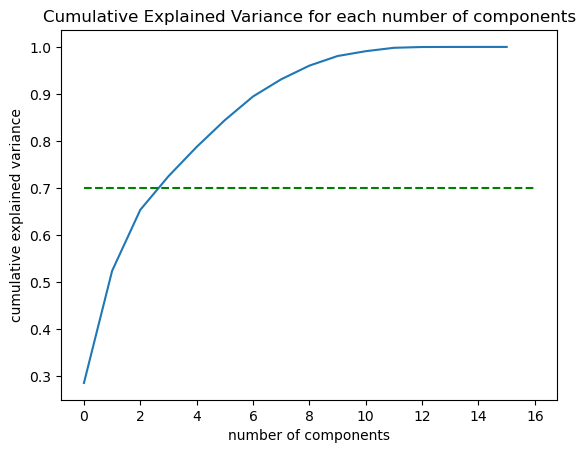

In [16]:
plt.plot(np.cumsum(variances))
plt.hlines(0.7,xmin=0,xmax=16,colors='green',linestyles='--')
plt.ticklabel_format(axis="y", style="plain")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative Explained Variance for each number of components')
plt.show()

Hence, we observe that by selecting only the 5 features with more variance, we obtain a fraction of our dataset that retains more than the $70\%$ of the variance. In fact,

In [11]:
pca=PCA(n_components=5)
dataPCA=pca.fit_transform(norm_data)
variances=(pca.explained_variance_ratio_)
print(variances)
print(np.sum(pca.explained_variance_ratio_))

[0.28601014 0.23821089 0.12966604 0.07136901 0.06230547]
0.7875615549750624


Observe that we only we obtain the $78.76\%$ of the total variance. And the data obtained is:

In [12]:
pca_data=pd.DataFrame(dataPCA)
pca_data.head()

,0,1,2,3,4
0,4.817054,-0.586794,-0.277843,0.201062,0.247229
1,-0.832107,0.150922,-0.039666,0.378790,-0.134573
2,4.690688,-1.213728,-0.135045,0.637628,0.254586
3,-1.212687,-0.327942,-0.404314,-0.029126,0.239815
4,-0.540078,1.187824,0.083150,-0.502009,-0.181859


Now we match the inital data that we had with the one we have obtained from PCA to see which feature are we selecting as the ones mantaining the most variance among them all.

In [13]:
final_data = data.join(pca_data) 
final_data

,N_Transactions,N_Transaction_100,AverageAmount,Average Balance,Utilisation,MostCommonGender,MostFreqLocation,MaxTransaction,MinTransaction,MostFreqTime,...,LogCustAccountBalance,Increment,TotalTransactions,Num_Cities,NightTransactions,0,1,2,3,4
0,2,2,2553.0,76340.635,73787.635,F,CHENNAI,4750,356,12,...,5.1838,87679.81,5106,2,1,4.817054,-0.586794,-0.277843,0.201062,0.247229
1,1,1,1499.0,24204.490,22705.490,M,MOHALI,1499,1499,20,...,4.3839,0.00,1499,1,0,-0.832107,0.150922,-0.039666,0.378790,-0.134573
2,2,2,727.5,100112.950,99385.450,F,DELHI,1205,250,15,...,5.3015,123471.62,1455,2,1,4.690688,-1.213728,-0.135045,0.637628,0.254586
3,1,1,30.0,496.180,466.180,F,GURGAON,30,30,17,...,2.6956,0.00,30,1,0,-1.212687,-0.327942,-0.404314,-0.029126,0.239815
4,1,1,5000.0,87058.650,82058.650,M,DELHI,5000,5000,14,...,4.9398,0.00,5000,1,0,-0.540078,1.187824,0.083150,-0.502009,-0.181859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879352,1,1,590.0,8752.390,8162.390,M,BANGALORE,590,590,13,...,3.9421,0.00,590,1,0,-0.972510,-0.130858,-0.127072,-0.640622,0.009153
879353,1,1,691.0,133067.230,132376.230,M,HAORA,691,691,0,...,5.1241,0.00,691,1,1,-0.537152,-0.146333,0.301511,-1.104732,-0.065782
879354,1,1,222.0,96063.460,95841.460,M,PUNE,222,222,12,...,4.9826,0.00,222,1,0,-0.810131,-0.195286,0.264726,-0.807159,-0.211282
879355,1,1,126.0,5559.750,5433.750,M,BANGALORE,126,126,12,...,3.7451,0.00,126,1,0,-1.034822,-0.271912,-0.160172,-0.784210,0.055821


In [272]:
final_data.to_csv('PCA_Data.csv',sep='\t')
final_data.to_pickle('PCA_Data.pkl')


In [135]:
pca_data.to_csv('PCA.csv')

## 2.3.- Clustering

Now we will give our own implementation of **K-Means** using MapReduce to compute the clusters of our data.

We will do as follows:

Given the data `D`, the number of clusters we are looking for `n`. 

- We will randomly select `n` points from our data as our initial centroids: $\{\mu_1,\cdots,\mu_n\}$.
- For all point in our data, we compute the square distance to all the centroids. 
- We pick the minimum among them and assign that point to the same cluster as that centroid.
- Once we have all the points assigned to the data, we will compute the new centroids by taking the average of all point in the same cluster.

We will iterate the procedure `k` times or stop as soon as the centroids have converged.

In [55]:
import pyspark
from pyspark.sql import SparkSession

In [139]:
sc = pyspark.SparkContext('local')

In [57]:
sc

<SparkContext master=local appName=pyspark-shell>

In [121]:
#Create SparkSession
spark = SparkSession.builder.appName('HW4_ADM').getOrCreate()

We first initialize the centroids of the clusters:

In [119]:
np.random.randint(100, size = 5)

array([97,  1, 18,  0,  4])

In [122]:
def Initial_Centroids(data, n):
    #Data is the data from where we will randomly pick the centroids
    #N is the number of centroids, or equivalenetly the number of clusters that we want.
    print("Taking a sample")
    idx= np.random.randint(len(data),size=n)
    cent = data[idx]
    print("Took sample")
    return cent
    

Secondly, once we have assigned the centroids, the `KMeansMap` function, will recieve the data and assign each data to the centroid which is closest (if the closest is the centroid `k`, the data will belong to the cluster `k`).

In `KMeans_NewCent`, given a centroid and the points that belong to that same cluster, we will compute the average to get the new centroid.

In [40]:
def KMeans_Map(data,centroids):
    Cluster,dist=0,np.inf #First we assign the data to cluster 0 and set the distance to infinity
    
    for i in range(len(centroids)): #For every centroid
        dist_aux=0
        
        for j in range(len(data)):
            dist_aux+=(data[j]-centroids[i][1][j])**2 #We compute the distance from every data point to it 
        
        dist_aux=np.sqrt(dist_aux)
        
        if dist_aux<dist:    #And if it is smaller than the one we had before, we update it and also the Cluster.
            dist=dist_aux
            Cluster=centroids[i][0] #The number assigned to that centroid, hence, the index of the cluster
            
    return((Cluster,[data]))
            
def KMeans_NewCent(info): #Info will contain the idx of the cluster and all the data in it
    
    points=info[1]
    
    #To be more efficient, we store and work with Numpy arrays:
    
    s=np.zeros(len(info[0])) #Here we'll store the sum of the points of the cluster
    
    for i in points:
        aux=np.array(i)
        s+=aux
    #and now we take the average
    New_Cent=s/len(points)
    
    return (info[0],tuple(New_Cent)) #We return the index of the cluster and its new centroid

### 2.3.1.- K-Means With MapReduce

In [33]:
#We first convert the dataframe into a pyspark dataframe to be able to use it properly in the PySpark enviroment.
sparkDF=spark.createDataFrame(pca_data) 
sparkDF.printSchema()
sparkDF.show()

root
 |-- 0: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)



22/12/01 12:43:32 WARN TaskSetManager: Stage 0 contains a task of very large size (41247 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+--------------------+--------------------+--------------------+
|                   0|                   1|                   2|                   3|                   4|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|    4.81705385740535| -0.5867936467761674| -0.2778429666293512| 0.20106229583400329| 0.24722894832072162|
| -0.8321065902034904| 0.15092193316190117|-0.03966599435125...|  0.3787899850207794|-0.13457313761397535|
|    4.69068763978951|  -1.213728079814547|-0.13504542810395473|  0.6376275347193192|  0.2545863648258934|
| -1.2126874673966022| -0.3279424382594832|-0.40431435866821375|-0.02912558403133...|  0.2398147309771022|
| -0.5400780255985524|  1.1878244253492674| 0.08314999866071975| -0.5020093060276052| -0.1818594710125635|
| -0.6960992687365467|-0.05568879906261...|  0.7050976678602136|  -1.249127902145607|   -0.29726847670509|
|  2.1989383370318367| -0.68298621986

In [128]:
aux=sparkDF.rdd
input_Kmeans=aux.map(lambda x: (x[0],x[1],x[2],x[3],x[4])) #And we split the data in tuples

In [136]:
def KMeansMR(data,n,k=30): #n --> number of clusters and #k --> number of maximum iteratons 
    
    #We compute the inital centroids and make lists so we can add all the data that goes into each
    
    centroids=Initial_Centroids(data,n)
    centroids=list(enumerate(centroids))
    
    j=0#j will count the iterations
    output=None
    
    while True:
        j+=1
        if j>=k:
            print('Number of Maximum Iterations exceeded.')
            return Result, centroids
        # Each datapoint will be assigned to a cluster and what the function returns is:
        #
        cluster_data  = data.map(lambda x: KMeans_Map(x, centroids))
        
        print("Clustered Data")
        # (cluster, [list points in this cluster])
        #
        
        reduced_data = cluster_data.reduceByKey(lambda x, y: x + y )
        
        print("Reduced Data")
        # Update the centroids 
        # 
        centroids_new = reduced_data.map(lambda x: KMeans_NewCent(x))
        
        print(f"Centroids at iteration {j}:", centroids_new)
        
        # If our centroids have converged
        #
        if centroids == centroids_new.collect():
            
            # Take the clusters 
            #
            output = cluster_data.collect()
            
            # Return the clusters and also the mean of each cluster
            #
            return output, centroids
        
        # Update the centroids if a change has occurred
        centroids = centroids_new.collect()
        

Now we have written the code to implement `KMeans` using `MapReduce`. The next thing we are going to do is the following:

### 2.3.2.- Optimal Number of Clusters

In order to find the optimal number of clusters for our data we will implement two methods: the `Elbow Method` and the `Silhouette Method`.

In [15]:
from sklearn.cluster import KMeans

We will  use this function as it has already been implemented in the library `yellowbrick`.

In [214]:
#First we will implement the elbow method to get a visualization of how the distances decrease as the number
#of clusters increases and determine a value for which the decreasing slows its rate.
from sklearn.cluster import KMeans

em={}
for k in tqdm(range(2,50)):
    model=KMeans(n_clusters=k,init='random')
    model.fit(pca_data)
    em[k]=model.inertia_

100%|███████████████████████████████████████████| 48/48 [28:04<00:00, 35.10s/it]


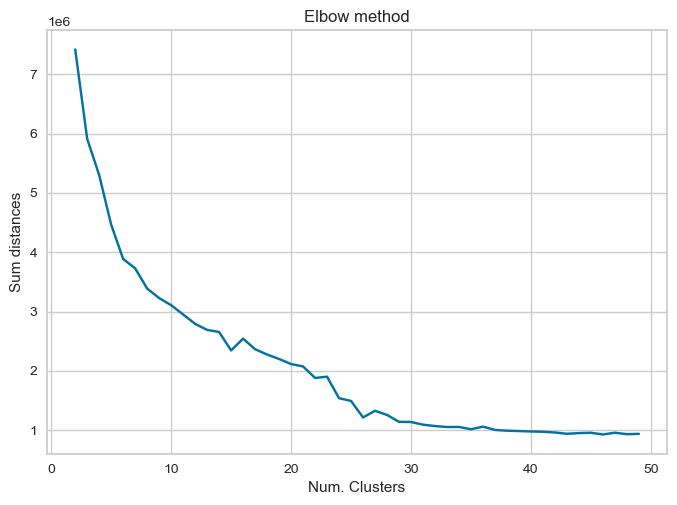

In [215]:
plt.figure()
plt.plot(list(em.keys()), list(em.values()))
plt.xlabel('Num. Clusters')
plt.ylabel('Sum distances')
plt.title('Elbow method')
plt.show()

From this visualization of the `Elbow Method`, we may say the the optimal number of clusters is arounds `n=10`. Let us know see what we do obtain from the `InterCluster Distance`.

For the `InterCluster Distance`, we first give some details of its implementation:

Intercluster distance maps shows the cluster centers in 2 dimensions mantaining the distance to other centers. 

The clusters are also sized according to the scoring metric.

**Important**: Note that the fact that two clusters seem to be overlapping in 2D, does not mean that they do in the original feature space.


$ $

$ $

Notice that if we try to compute some distance between the obtained centers we fall back into the Elbow method, so we are just going to give a few plots for some values of `n_clusters`.

  0%|                                                    | 0/13 [00:00<?, ?it/s]

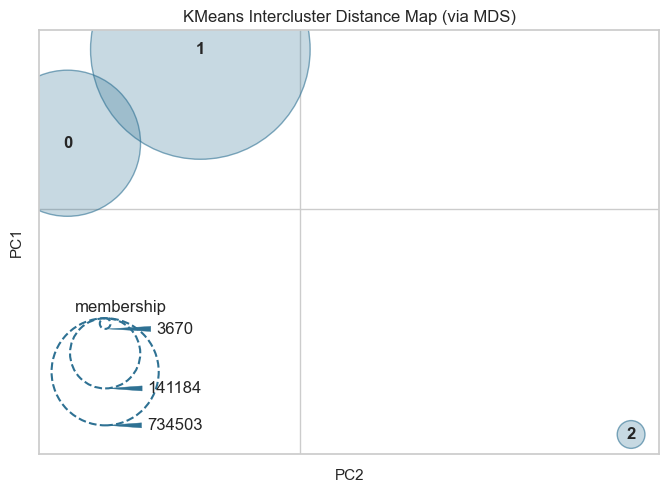

  8%|███▍                                        | 1/13 [00:01<00:20,  1.73s/it]

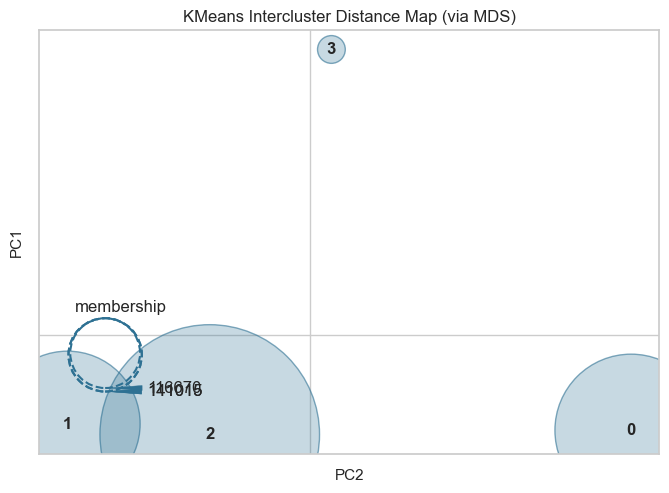

 15%|██████▊                                     | 2/13 [00:04<00:23,  2.17s/it]/Users/ericraguilera/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


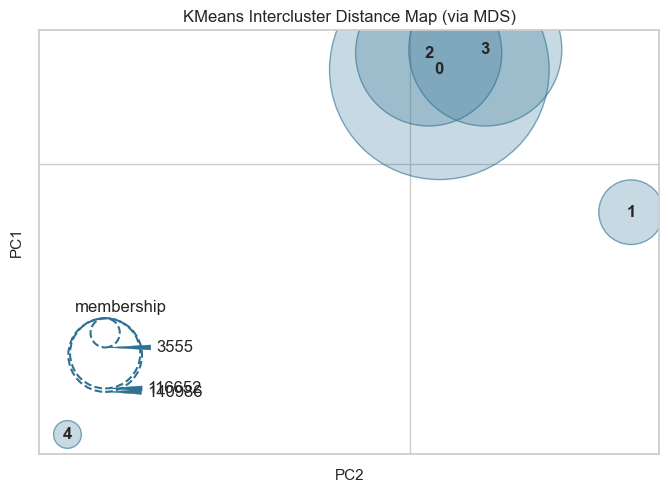

 23%|██████████▏                                 | 3/13 [00:07<00:26,  2.65s/it]

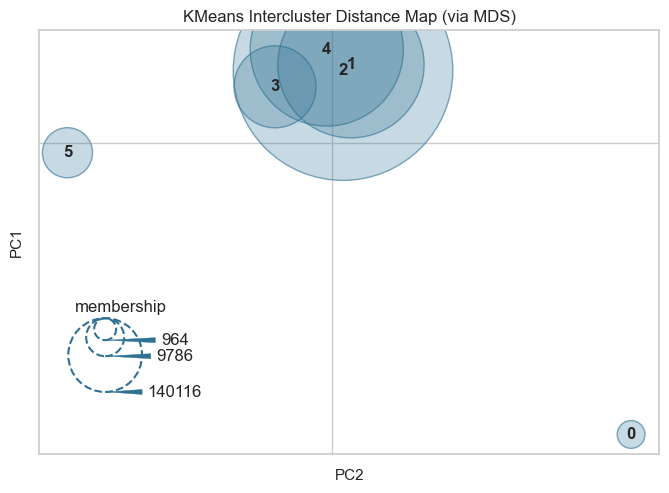

 31%|█████████████▌                              | 4/13 [00:11<00:29,  3.28s/it]

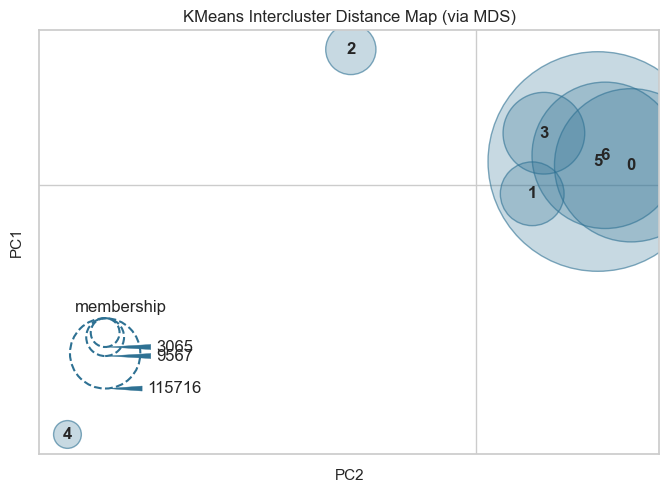

 38%|████████████████▉                           | 5/13 [00:17<00:32,  4.03s/it]

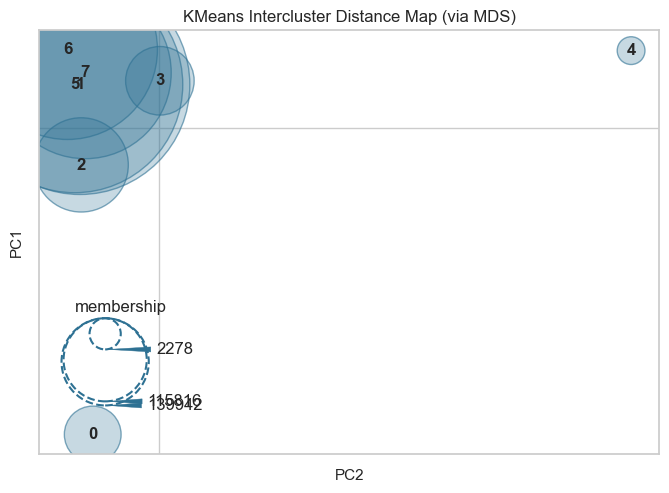

 46%|████████████████████▎                       | 6/13 [00:21<00:29,  4.22s/it]

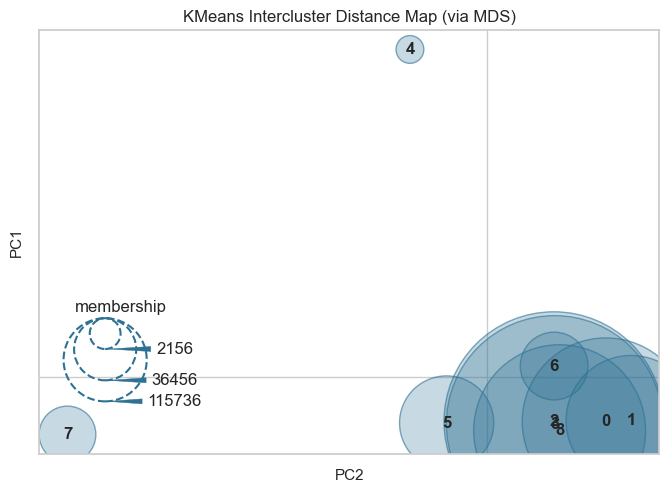

 54%|███████████████████████▋                    | 7/13 [00:27<00:28,  4.76s/it]

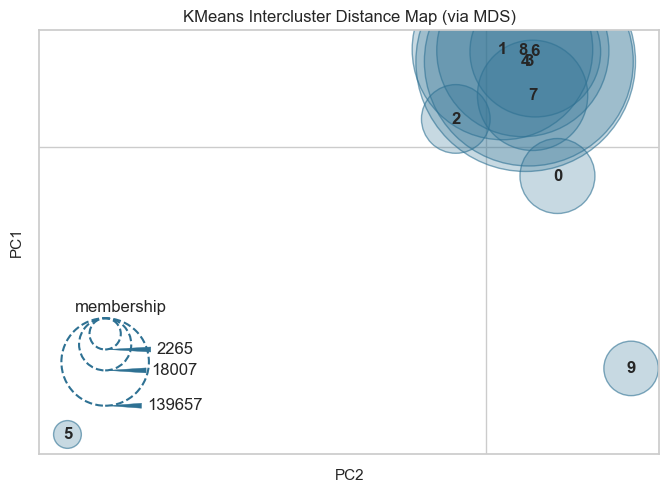

 62%|███████████████████████████                 | 8/13 [00:33<00:25,  5.03s/it]

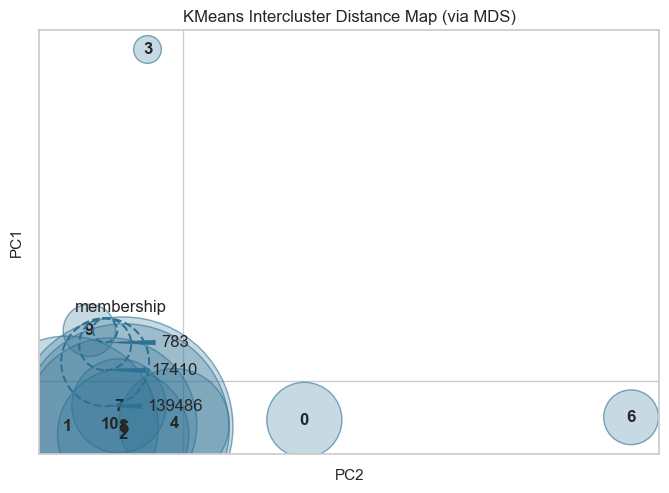

 69%|██████████████████████████████▍             | 9/13 [00:40<00:22,  5.75s/it]

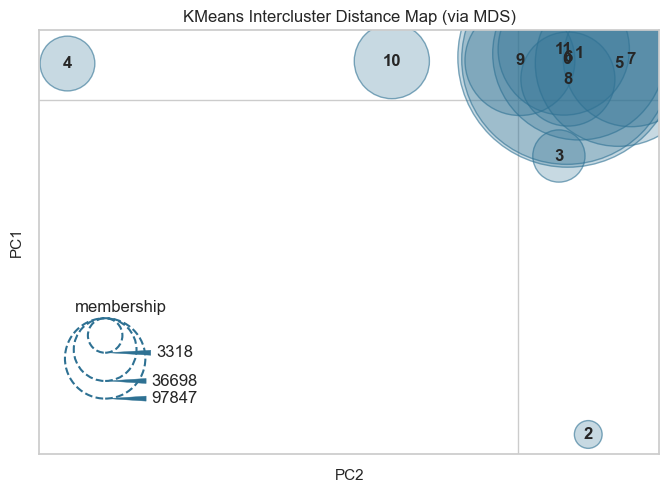

 77%|█████████████████████████████████          | 10/13 [00:48<00:19,  6.37s/it]

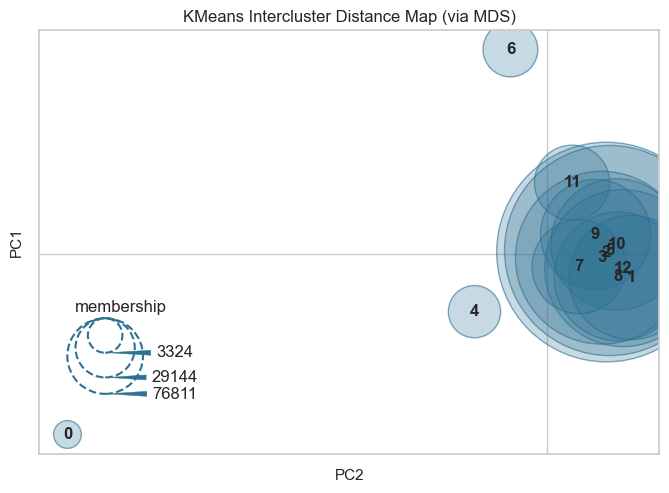

 85%|████████████████████████████████████▍      | 11/13 [00:57<00:14,  7.21s/it]

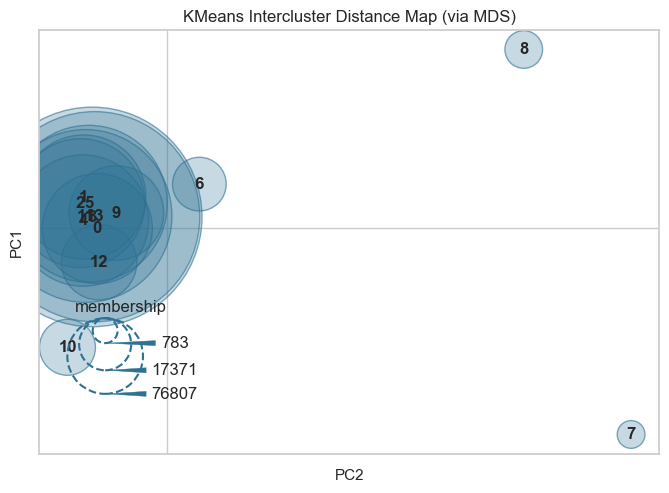

 92%|███████████████████████████████████████▋   | 12/13 [01:06<00:07,  7.85s/it]

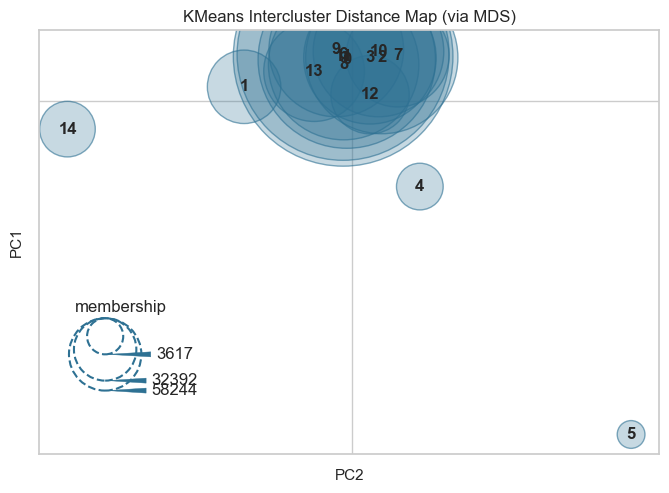

100%|███████████████████████████████████████████| 13/13 [01:17<00:00,  5.93s/it]


In [225]:

for k in tqdm(range(3,16)): 
    model=KMeans(n_clusters=k,init='random')
    intercluster_distance(model,pca_data)


Among these very few plots, we observe that the ones that have between 10 and 14 clusters, have less overlaps in the 2D of the plot. We must keep in mind that the actual overlapping in 2D does not imply that they actually overlap in the 5D of the features. Hence, we will proceed with **`n=12`**.

### 2.3.3.- Run the Algorithm on the Data!

In [147]:
model=KMeans(n_clusters=6,init='random')
result=model.fit(pca_data)


In [148]:
clusters_KMeans=result.labels_

In [412]:
#Here we store the sum of the square distances that we will later compare with the result from K-Means++

dist_KMeans=round(result.inertia_ ,2)

### 2.3.4.- Implement K-Means ++ from `scikit-learn` 

In [150]:
#Here we simply implement the version of K-Means++ in sickit-learn

model_2=KMeans(n_clusters=6,init='k-means++')
model_2.fit(pca_data)

#We also save the sum of the square distances to compare with our other previous result
dist_2=round(model_2.inertia_,2)

And now we compare both results to see which ones is better:

In [151]:
print(f'For the randomized K-Means we get: {dist_KMeans} \n            and for the K-Means++: {dist_2}')

For the randomized K-Means we get: 3886200.05 
            and for the K-Means++: 3753954.87


So, the randomized version is worse than the `KMeans++` one, we observe that moving to the 2nd version the sum of the squared distances decreases around a $3\%$ from the previous implementation.

In [152]:
1-dist_2/dist_KMeans

0.03402943191254393

In [153]:
aux=(model_2.labels_==model.labels_)
aux2=Counter(aux)
print(aux2)
print(f'{aux2[True]/aux2[False]*100}%')

Counter({False: 874002, True: 5355})
0.6126988267761401%


Also, we observe that the cluster where the values are assigned with the `KMeans++` implementation *barely ever* match the ones assigned by the randomized `KMeans`.

In [154]:
#Finally we add a column into the `final_Data` dataframe to assign each data point into its cluster.
final_data['Cluster']=clusters_KMeans+1
final_data.head()

,N_Transactions,N_Transaction_100,AverageAmount,Average Balance,Utilisation,MostCommonGender,MostFreqLocation,MaxTransaction,MinTransaction,MostFreqTime,...,Increment,TotalTransactions,Num_Cities,NightTransactions,0,1,2,3,4,Cluster
0,2,2,2553.0,76340.635,73787.635,F,CHENNAI,4750,356,12,...,87679.81,5106,2,1,4.817054,-0.586794,-0.277843,0.201062,0.247229,1
1,1,1,1499.0,24204.490,22705.490,M,MOHALI,1499,1499,20,...,0.00,1499,1,0,-0.832107,0.150922,-0.039666,0.378790,-0.134573,4
2,2,2,727.5,100112.950,99385.450,F,DELHI,1205,250,15,...,123471.62,1455,2,1,4.690688,-1.213728,-0.135045,0.637628,0.254586,1
3,1,1,30.0,496.180,466.180,F,GURGAON,30,30,17,...,0.00,30,1,0,-1.212687,-0.327942,-0.404314,-0.029126,0.239815,4
4,1,1,5000.0,87058.650,82058.650,M,DELHI,5000,5000,14,...,0.00,5000,1,0,-0.540078,1.187824,0.083150,-0.502009,-0.181859,4


## 2.4.- Analysing your results!

Now we will choose  2-3 variables that we  think are relevant to identify the cluster of the customer.

These will be `Average Balance`,`AverageAmount` and `MinTransaction`.

$ $

To create pivot tables, we choose the given feature and the `cluster` column. After, we use `pivot_table` from pandas, selecting as index the variable we earlier chose and as column the cluster. Finally, we compute the percentage for each column.

In [390]:
chosen_features=final_data[['Average Balance','AverageAmount','MinTransaction','Cluster']]

In [391]:
chosen_features.describe()

,Average Balance,AverageAmount,MinTransaction,Cluster
count,8.793570e+05,8.793570e+05,8.793570e+05,879357.000000
mean,1.147151e+05,1.566734e+03,1.374435e+03,3.249200
std,8.010842e+05,6.433249e+03,6.243189e+03,1.189132
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
25%,5.591270e+03,1.905000e+02,1.300000e+02,2.000000
50%,1.866578e+04,5.000000e+02,3.750000e+02,4.000000
75%,6.154197e+04,1.241000e+03,1.000000e+03,4.000000
max,1.150355e+08,1.560034e+06,1.560034e+06,6.000000


$ $

Before we do that, we will divide the chosen features into $4$ categories:


### Average Amount Categorisation

First we will go for the `AverageAmount` Feature:

In [393]:
chosen_features['AverageAmount']=pd.qcut(chosen_features.AverageAmount,[0,0.25,0.5,0.75,1],labels=['Low Amount','Medium Amount','Big Amount','Very Big Amount'])

In [230]:
chosen_features.head()

,Average Balance,AverageAmount,MinTransaction,Cluster
0,76340.635,V Big T,356,1
1,24204.490,V Big T,1499,4
2,100112.950,Big T,250,1
3,496.180,Low T,30,4
4,87058.650,V Big T,5000,4


We have classifies them into 4 categories for the `AverageAmount`:
- **Low Amount**: If the amount of the user is between the minimum and the 1st quartile of the values of this feature.
- **Medium Amount**: If the amount of the user is between the 1st and the 2nd quartile of the values of this feature.
- **Big Amount**: If the amount of the user is between the 2nd and the 3rd quartile of the values of this feature.
- **Very Big Amount**: If the amount of the user is between the 3rd quartile and the maximum value of the values of this feature.

### Min Transaction Categorisation

In [396]:
chosen_features['MinTransaction']=pd.qcut(chosen_features.MinTransaction,[0,0.25,0.5,0.75,1],labels=['Little T','Hundreds T','Thousand T','Big T'])

In [395]:
chosen_features.head()

,Average Balance,AverageAmount,MinTransaction,Cluster
0,76340.635,Very Big Amount,Hundreds T,1
1,24204.490,Very Big Amount,Big T,4
2,100112.950,Big Amount,Hundreds T,1
3,496.180,Low Amount,Little T,4
4,87058.650,Very Big Amount,Big T,4


We have classifies them into 4 categories for the `MaxTransaction`:
- **Little T**: Max T that are below the 1st quartile

- **Hunderds T**: Max T that are between the 1st and the 2nd quartile (a few hunderds of the currency, that is the reason for the name).

- **Thousand T**: Max T that are between the 2nd and the 3rd quartile (around 1000 of the currency, that is the reason for the name).

- **Big T**: Max T that are above the 3rd quartile.

### Average Balance Categorisation

In [398]:
chosen_features['Average Balance']=pd.qcut(chosen_features['Average Balance'],[0,0.25,0.5,0.75,1],labels=['Few Thousands Balance',' 10 Thousands Balance','50 Thousands Balance','Higher Balance'])

We have classifies them into 4 categories for the `LogCustAccountBalance`:

- **Few Thousands Balance**: Avg. Balance below 10.000 currency units.

- **10 Thousands Balance**: Avg. Balance around 10.000-15.000 currency units.

- **50 Thousands Balance**: Avg. Balance above 16.000 and below 60.000 currency units.

- **Higher Balance**: Avg. Balance above 60.000 currency units.

Hence, we end up with the following features in a DataFrame to compute the pivot tables.

In [399]:
chosen_features

,Average Balance,AverageAmount,MinTransaction,Cluster
0,Higher Balance,Very Big Amount,Hundreds T,1
1,50 Thousands Balance,Very Big Amount,Big T,4
2,Higher Balance,Big Amount,Hundreds T,1
3,Few Thousands Balance,Low Amount,Little T,4
4,Higher Balance,Very Big Amount,Big T,4
...,...,...,...,...
879352,10 Thousands Balance,Big Amount,Thousand T,4
879353,Higher Balance,Big Amount,Thousand T,4
879354,Higher Balance,Medium Amount,Hundreds T,4
879355,Few Thousands Balance,Low Amount,Little T,4


#### Pivot 1:   Average Amount

In [405]:
pivot_amount = chosen_features[['AverageAmount','Cluster']]

pivot_amount = pd.pivot_table(data=pivot_amount, index='Cluster', columns='AverageAmount', 
                              aggfunc=len,fill_value=0,margins=True,margins_name='Sum')

pivot1 = round(pivot_amount.div( pivot_amount.iloc[:,-1], axis=0)*100,2)


In [406]:
pivot1

AverageAmount,Low Amount,Medium Amount,Big Amount,Very Big Amount,Sum
Cluster,,,,,
1,13.68,26.32,31.98,28.03,100.0
2,27.19,28.84,22.27,21.70,100.0
3,0.00,0.00,0.01,99.99,100.0
4,27.62,27.54,21.24,23.60,100.0
5,10.79,8.63,8.63,71.94,100.0
6,0.00,0.00,0.00,100.00,100.0
Sum,25.00,27.18,22.83,24.99,100.0


When we focus our study on this feature, `Average Amount`, we notice that:
- Observe that in clusters $1,2$ and $4$ the number of customers that fall into the category of `V Big T` is pretty similar and much smaller than in clusters $3,5,6$. In fact, in $5$ it is a bit lass than $75\%$ but in $3$ and $6$ it essentially is the whole set of customers in that clustes.
- Overall, the percentage of each class within cluste $2$ and $4$ is very uniform. As for cluster $5$, $10\%$ of the population is in the `Low Amount` class and the remaining $16\%$ is equally distributed among the remaining classes.

#### Pivot 2:  MinTransaction

In [408]:
pivot_min = chosen_features[['MinTransaction','Cluster']]

pivot_min = pd.pivot_table(data=pivot_min, index='Cluster', columns='MinTransaction', 
                              aggfunc=len,fill_value=0,margins=True,margins_name='Sum')

pivot2 = round(pivot_min.div(pivot_min.iloc[:,-1], axis=0)*100,2)
pivot2.drop('Sum',inplace=True)

In [409]:
pivot2

MinTransaction,Little T,Hundreds T,Thousand T,Big T,Sum
Cluster,,,,,
1,41.16,31.50,20.42,6.92,100.0
2,21.43,25.45,27.10,26.01,100.0
3,3.60,3.02,3.41,89.97,100.0
4,22.38,23.84,26.21,27.58,100.0
5,13.67,14.39,7.91,64.03,100.0
6,1.35,1.97,0.93,95.75,100.0


When we focus our study on this feature, `Min Transaction`, we notice that:
- In clusters $3$ and $6$, at least around a $90\%$ of the population fall into the class of `Big T`.
- On the contrary, in cluster $1$, almost half of the population is in `Little T`, around a third is in `Hundreds T` and there is slightly more than a $5\%$ in the `Big T` class.
- Notice that both clusters $2$ and $4$ distribute uniformly over the classes of this feature. To state some really non-remarkable differences, in the classes `Little T` and `Big T`, there is a little more percentage in cluster $4$ than in $2$ and opposite for the other 2 classes.

#### Pivot 3 : Average Balance

In [410]:
pivot_b = chosen_features[['Average Balance','Cluster']]

pivot_b = pd.pivot_table(data=pivot_b, index='Cluster', columns='Average Balance', 
                              aggfunc=len,fill_value=0,margins=True,margins_name='Sum')

pivot3 = round(pivot_b.div(pivot_b.iloc[:,-1], axis=0)*100,2)

pivot3.drop('Sum',inplace=True)

In [411]:
pivot3

Average Balance,Few Thousands Balance,10 Thousands Balance,50 Thousands Balance,Higher Balance,Sum
Cluster,,,,,
1,11.70,25.89,31.47,30.94,100.0
2,28.22,25.52,24.11,22.15,100.0
3,11.15,12.28,23.10,53.46,100.0
4,27.69,24.93,23.74,23.63,100.0
5,0.00,0.00,0.00,100.00,100.0
6,5.29,8.61,11.41,74.69,100.0


When we focus our study on this feature, `Average Balance`, we notice that:
- As we have seen when looking to the other features, the distribution of clusters $2$ and $4$ is very similar and uniform along the classes.
- All of the customer that are in cluster $5$ fall into the `Higher Balance` class.
- $75\%$ of the customer in cluster $6$ are in `Higher Balance` class, a bit more than $10\%$ in `50 Thousand Balance`, around a $5\%$ in `Few Thousands` and the rest in he remaining class. A similar distributions happens within cluster $3$ but with with a more balanced concentration among all the classes. 
- Finally, the percentage of customers in cluster $1$ that are in the classes of `10 Thousands Balance` and `50 Thousands Balance` is the greatest among the rest, separately, and being around a $30\%$ and $26\%$ respectively. The percentage of customer in class `10 Thousands Balance` is approximately $25\%$ in clusters $1,2$ and $4$.  


### Cluster's Score

As we have already implemented previously, in the variable `result` we have al the information regarding our implementation:

In [419]:
print(f'The algorithm did {result.n_iter_} iterations until it converged.')

The algorithm did 28 iterations until it converged.


In [430]:
print(f'The algorithm provides centroids and clusters such that the sum of squared distance from the each data point to the centroid of the cluster where it belongs to is {round(result.inertia_,2)}, measured with euclidean distance.')

The algorithm provides centroids and clusters such that the sum of squared distance from the each data point to the centroid of the cluster where it belongs to is 3886200.05, measured with euclidean distance.
